<a href="https://colab.research.google.com/github/siruku6/thesis-trial/blob/master/220807_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modules


In [3]:
!pip install -q pytorch_lightning torchmetrics torchinfo

     |████████████████████████████████| 700 kB 21.5 MB/s 
     |████████████████████████████████| 419 kB 40.0 MB/s 
     |████████████████████████████████| 141 kB 44.1 MB/s 
     |████████████████████████████████| 596 kB 32.1 MB/s 
     |████████████████████████████████| 5.8 MB 43.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.9.1 which is incompatible.


In [1]:
from typing import List, Union

from google.colab import files
import numpy as np
import scipy.io as sio

# wake sleep
from itertools import islice

# VAE
import os

from tqdm.notebook import tqdm

from torch.autograd import Variable
import torch
import torch.utils.data
from torch import nn
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.nn import functional as F

# visualize chart
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
# Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import torchmetrics
# from torchmetrics.functional import accuracy
from torchinfo import summary

# データの準備

## ※frey_faceを学習させる場合

以下のセルを実行しておく

In [ ]:
!wget https://cs.nyu.edu/~roweis/data/frey_rawface.mat -P data

--2022-08-07 07:32:50--  https://cs.nyu.edu/~roweis/data/frey_rawface.mat
Resolving cs.nyu.edu (cs.nyu.edu)... 216.165.22.203
Connecting to cs.nyu.edu (cs.nyu.edu)|216.165.22.203|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1100584 (1.0M)
Saving to: ‘data/frey_rawface.mat’

frey_rawface.mat    100%[===================>]   1.05M  --.-KB/s    in 0.1s    

2022-08-07 07:32:51 (10.8 MB/s) - ‘data/frey_rawface.mat’ saved [1100584/1100584]



In [5]:
def get_dataloader(is_training_data: bool = True) -> torch.utils.data.DataLoader:
    location = "data/mnist"
    os.makedirs(location, exist_ok=True)
    dataloader = torch.utils.data.DataLoader(
        datasets.MNIST(
            location,
            train=is_training_data,
            download=True,
            transform=transforms.Compose([transforms.ToTensor()]),
        ),
        batch_size=100,
        shuffle=is_training_data,
    )
    return dataloader


# Loads Frey Face dataset
IMG_CHANNELS = 1
IMG_HEIGHT = 28
IMG_WIDTH = 20

def get_FreyFace_data_loader(
    batchSize: int = 100, is_training_data: bool = True
) -> torch.utils.data.DataLoader:
    ff = sio.loadmat('data/frey_rawface.mat')
    ff = ff["ff"].T  # .reshape((-1, IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH))
    ff = ff.astype('float32') / 255.
    size = len(ff)
    ff = ff[:int(size / batchSize) * batchSize]
    ff_torch = torch.from_numpy(ff)

    testStart = int(0.5 * size)
    if is_training_data:
        data_set = ff_torch[:testStart]
    else:
        data_set = ff_torch[testStart:]

    data_loader = torch.utils.data.DataLoader(data_set, batchSize, shuffle=is_training_data)
    return data_loader


# 1. copied VAE

https://github.com/octopt/techblog/blob/master/vae/main.py

## 1-1 Define encoder / decoder / VAE / loss func

In [6]:
class Encoder( nn.Module ):
    def __init__( self ):
        super().__init__()
        self.common = nn.Sequential(
            nn.Linear( 784, 400 ),
            nn.ReLU(),
            )
        self.model1 = nn.Sequential(
            self.common,
            nn.Linear( 400, 20 )
            )
        self.model2 = nn.Sequential(
            self.common,
            nn.Linear( 400, 20 )
            )
    def forward( self, img ):
        img_flat = img.view( img.size( 0 ), -1 )
        return self.model1( img_flat ), self.model2( img_flat )


class Decoder( nn.Module ):
    def __init__( self ):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear( 20, 400 ),
            nn.ReLU(),
            nn.Linear( 400, 784 ),
            nn.Sigmoid(),
            )
    def forward( self, z ):
        return self.model( z )


class VAE( nn.Module ):
    def __init__( self ):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def _reparameterization_trick( self, mu, logvar ):
        std = torch.exp( 0.5 * logvar )
        eps = torch.randn_like( std )
        return mu + eps * std
    
    def forward( self, _input ):
        mu, sigma = self.encoder( _input )
        z         = self._reparameterization_trick( mu, sigma )
        return self.decoder( z ), mu, sigma


# Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
def VAE_LOSS( recon_x, x, mu, logvar ):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), size_average=False)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


## 1-2 Run

In [ ]:
def main():
    epoch_size = 30  # 50
    vae = VAE()
    Tensor = torch.FloatTensor
    
    USE_GPU = False  # True
    if USE_GPU:
        vae.cuda()
        Tensor = torch.cuda.FloatTensor
    dataloader=get_dataloader()
    optimizer = torch.optim.Adam( vae.parameters(), lr=1e-3 )
    
    folder_name: str = "images"
    os.makedirs(folder_name, exist_ok=True)

    losses_per_epoch = []
    for epoch in tqdm(range( epoch_size )):
        losses_per_steps = []
        for i, ( imgs, _ ) in enumerate(tqdm(dataloader)):
            optimizer.zero_grad()
            real_images          = Variable( imgs.type( Tensor ) )
            gen_imgs, mu, logvar = vae( real_images )
            loss                 = VAE_LOSS( gen_imgs, real_images, mu, logvar )
            if USE_GPU:
                loss = loss.cuda()
            loss.backward()
            optimizer.step()
            # print(
            #     "[Epoch %d/%d] [Batch %d/%d] [Loss: %f]"
            #     % (epoch, epoch_size, i, len(dataloader), loss.item())
            # )

            losses_per_steps.append(loss.cpu().detach().numpy())
            # if i % 50 == 0:
            #     save_image( gen_imgs.view(64, 1, 28, 28), f"{folder_name}/%d.png" % (i * epoch), normalize=True)

        print(
            "[Epoch %d/%d] [Batch %d/%d] [Loss: %f]"
            % (epoch, epoch_size, i, len(dataloader), np.average(losses_per_steps))
        )

        losses_per_epoch.append(np.average(losses_per_steps))


main()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


[Epoch 0/30] [Batch 599/600] [Loss: 15632.843750]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 1/30] [Batch 599/600] [Loss: 11861.429688]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 2/30] [Batch 599/600] [Loss: 11310.713867]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 3/30] [Batch 599/600] [Loss: 11048.328125]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 4/30] [Batch 599/600] [Loss: 10894.693359]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 5/30] [Batch 599/600] [Loss: 10789.827148]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 6/30] [Batch 599/600] [Loss: 10713.709961]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 7/30] [Batch 599/600] [Loss: 10657.626953]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 8/30] [Batch 599/600] [Loss: 10612.255859]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 9/30] [Batch 599/600] [Loss: 10572.732422]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 10/30] [Batch 599/600] [Loss: 10539.932617]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 11/30] [Batch 599/600] [Loss: 10509.073242]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 12/30] [Batch 599/600] [Loss: 10485.783203]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 13/30] [Batch 599/600] [Loss: 10460.643555]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 14/30] [Batch 599/600] [Loss: 10443.018555]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 15/30] [Batch 599/600] [Loss: 10422.212891]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 16/30] [Batch 599/600] [Loss: 10403.863281]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 17/30] [Batch 599/600] [Loss: 10390.341797]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 18/30] [Batch 599/600] [Loss: 10378.688477]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 19/30] [Batch 599/600] [Loss: 10362.259766]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 20/30] [Batch 599/600] [Loss: 10351.698242]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 21/30] [Batch 599/600] [Loss: 10338.506836]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 22/30] [Batch 599/600] [Loss: 10330.261719]


  0%|          | 0/600 [00:00<?, ?it/s]

## 1-3 Reference

- [OctOpt 技術ブログ / Variational AutoEncoder( VAE )](https://blog.octopt.com/variational-autoencoder/)



# 2. Wake-Sleep

- thesis  
https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.40.6587&rep=rep1&type=pdf
- source code
https://github.com/vadim0x60/wakesleep/blob/master/WakeSleep.ipynb

## 2-1 window function

In [ ]:
# I usually program in languages where this is built in :)
# https://stackoverflow.com/questions/6822725/rolling-or-sliding-window-iterator-in-python

def window(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

In [ ]:
list(window([1,2,3,4,5,6,7,8,9,10], n =3))

[(1, 2, 3),
 (2, 3, 4),
 (3, 4, 5),
 (4, 5, 6),
 (5, 6, 7),
 (6, 7, 8),
 (7, 8, 9),
 (8, 9, 10)]

## 2-2 Binary Stochastic Neuron

In [ ]:
class StochasticNeuron():
    def __init__(self, input_weights = np.array([]), bias = 0):
        self.input_weights = np.array(input_weights)
        self.bias = bias
        
    def activation_probability(self, inputs: Union[List, np.ndarray]) -> np.ndarray:
        inputs = np.array(inputs)
        outputs = 1 / (1 + np.exp(- self.bias - np.sum(self.input_weights * inputs)))
        return outputs
    
    def activation_function(self, inputs: Union[List, np.ndarray]) -> np.ndarray:
        return np.random.binomial(1, self.activation_probability(inputs))
    
    def __call__(self, inputs: Union[List, np.ndarray]) -> np.ndarray:
        return self.activation_function(inputs)


### 2-2-1 behaviour check

In [ ]:
n = StochasticNeuron([0, -0.5, 1], 0)
n.activation_probability([False, True, False])

0.3775406687981454

In [ ]:
n = StochasticNeuron([0, -0.5, 1], 0)
n.activation_probability([False, True, False])

0.3775406687981454

In [ ]:
n([False, True, False])

0

In [ ]:
n([False, True, False])

1

In [ ]:
[n([False, True, False]) for i in range(15)]

[1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0]

0

## 2-3 Stochastic neural networks

In [ ]:
# Unbiased, unadjusted layer
def create_layer(input_size: int, neuron_num: int) -> List[StochasticNeuron]:
    initial_weights: np.ndarray = np.array([1.0 for i in range(input_size)])
    layer: List[StochasticNeuron] = [
        StochasticNeuron(initial_weights, bias=0)
        for i in range(neuron_num)
    ]
    return layer


Layer = List[StochasticNeuron]


def create_network(layer_sizes) -> List[Layer]:
    """
    layer_sizes:
        Example: [3, 4, 3]
            This means that 1st layer includes 3 neurons, 2nd one includes 4 neurons and 3rd one does 3 layers.
    """
    layers: List[Layer] = [
        create_layer(input_size=prev_size, neuron_num=neuron_num)
        for prev_size, neuron_num in window(layer_sizes, 2)
    ]
    return layers


In [ ]:
layer = create_layer(input_size=3, neuron_num=10)

# Looking into behaviour of the neurons
sample_inputs = [1, 2, -4]
[neuron(sample_inputs) for neuron in layer]

[0, 1, 0, 1, 0, 0, 0, 0, 0, 0]

In [ ]:
net = create_network([3, 4, 2])
net

[[<__main__.StochasticNeuron at 0x7f6899b7c590>,

In [ ]:
def infer(layers: List[Layer], inputs) -> np.ndarray:
    def infer_once(input):
        state = [input]
        for layer in layers:
            state.append([neuron(state[-1]) for neuron in layer])
        return state

    # batch processing
    if len(np.array(inputs).shape) == 2:
        state = [infer_once(input) for input in inputs]
    # single processing
    else:
        state = infer_once(inputs)
    return state

In [ ]:
state = infer(net, [[1, 0, -1], [1, 0, 1]])
state

[[[1, 0, -1], [1, 1, 0, 0], [1, 1]], [[1, 0, 1], [1, 0, 1, 1], [1, 1]]]

In [ ]:
def learn(layers: List[Layer], states, lr: float):
    for layer, (inputs, outputs) in zip(layers, window(states, 2)):
        for neuron, output in zip(layer, outputs):
            # Yes, I could greatly optimize it by caching probabilities
            # As soon as I have some spare time
            p = neuron.activation_probability(inputs)
            for inpt, weight in zip(inputs, neuron.input_weights):
                loss = inpt * (output - p)
                neuron.input_weights -= np.array([lr * loss])


class WakeSleep:
    def __init__(self, layer_sizes) -> None:
        self.recognition_connections: List[Layer] = create_network(layer_sizes)
        self.generative_connections: List[Layer] = create_network(reversed(layer_sizes))

    def run(self, inputs, learning_rate: float, iterations: int):
        state = [inputs]
        
        for i in tqdm(range(iterations)):
            state = infer(self.recognition_connections, state[-1]) # That reverses state
            learn(
                self.generative_connections, reversed(state),
                learning_rate
            )

            state = infer(self.generative_connections, state[-1]) # That reverses it once again
            learn(
                self.recognition_connections, reversed(state),
                learning_rate
            )
        return reversed(state)

    def sample(self, inputs: np.ndarray) -> np.ndarray:
        """
        Parameters
            generatorへのinput

        Returns
            generator最終層の出力のみを返す
        """
        result_states = infer(self.generative_connections, inputs)
        return result_states[-1]

In [ ]:
wake_sleep = WakeSleep([6, 5, 10])
tuple(wake_sleep.run([-1, 1, 0, -1, -1, 0], 1, 10))


  0%|          | 0/10 [00:00<?, ?it/s]

([1, 0, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 0, 1, 1])

In [ ]:
# wake_sleep = WakeSleep([3, 4, 2])
# wake_sleep.recognition_connections[0][0].input_weights

wake_sleep.sample([1,2,-1,-1,-1,1,0,0,0,-1])

[1, 1, 1, 1, 0, 0]

# 3. Genuine VAE

In [ ]:
class Encoder( nn.Module ):
    def __init__( self ):
        super().__init__()
        self.common = nn.Sequential(
            nn.Linear( 784, 500 ),
            nn.ReLU(),
            )
        self.model1 = nn.Sequential(
            self.common,
            nn.Linear( 500, 10 )
            )
        self.model2 = nn.Sequential(
            self.common,
            nn.Linear( 500, 10 )
        )
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, 0, 0.01)
                nn.init.constant_(module.bias, 0)

    def forward( self, img ):
        img_flat = img.view( img.size( 0 ), -1 )
        return self.model1( img_flat ), self.model2( img_flat )


class Decoder( nn.Module ):
    def __init__( self ):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear( 10, 500 ),
            nn.ReLU(),
            nn.Linear( 500, 784 ),
            nn.Sigmoid(),
        )
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, 0, 0.01)
                nn.init.constant_(module.bias, 0)

    def forward( self, z ):
        return self.model( z )


class VAE( nn.Module ):
    def __init__( self ):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def _reparameterization_trick( self, mu, logvar ):
        std = torch.exp( 0.5 * logvar )
        eps = torch.randn_like( std )
        return mu + eps * std
    
    def forward( self, _input ):
        mu, sigma = self.encoder( _input )
        z         = self._reparameterization_trick( mu, sigma )
        return self.decoder( z ), mu, sigma


# Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
def VAE_LOSS( recon_x, x, mu, logvar ):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), size_average=False)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


def main(use_gpu: bool = False, epoch_size: int = 50):
    vae = VAE()
    Tensor = torch.FloatTensor
    
    if use_gpu:
        vae.cuda()
        Tensor = torch.cuda.FloatTensor
    dataloader = get_dataloader()
    optimizer = torch.optim.Adam( vae.parameters(), lr=1e-3, weight_decay=0.001 )
    # optimizer = torch.optim.Adagrad( vae.parameters(), lr=1e-3, weight_decay=0.001 )
    
    folder_name: str = "images"
    os.makedirs(folder_name, exist_ok=True)

    losses_per_epoch = []
    for epoch in tqdm(range( epoch_size )):
        losses_per_steps = []
        for i, ( imgs, _ ) in enumerate(tqdm(dataloader)):
            optimizer.zero_grad()
            real_images          = Variable( imgs.type( Tensor ) )
            gen_imgs, mu, logvar = vae( real_images )
            loss                 = VAE_LOSS( gen_imgs, real_images, mu, logvar )
            if use_gpu:
                loss = loss.cuda()
            loss.backward()
            optimizer.step()
            # print(
            #     "[Epoch %d/%d] [Batch %d/%d] [Loss: %f]"
            #     % (epoch, epoch_size, i, len(dataloader), loss.item())
            # )

            losses_per_steps.append(loss.cpu().detach().numpy())
            if i % 50 == 0:
                save_image( gen_imgs.view(-1, 1, 28, 28), f"{folder_name}/%d.png" % (i * epoch), normalize=True)

        print(
            "[Epoch %d/%d] [Batch %d/%d] [Loss: %f]"
            % (epoch, epoch_size, i, len(dataloader), np.average(losses_per_steps))
        )

        losses_per_epoch.append(np.average(losses_per_steps))

    return losses_per_epoch


In [ ]:
epoch_size = 50

losses = main(use_gpu=False, epoch_size=epoch_size)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


[Epoch 0/50] [Batch 599/600] [Loss: 15221.490234]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 1/50] [Batch 599/600] [Loss: 12163.578125]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 2/50] [Batch 599/600] [Loss: 11732.627930]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 3/50] [Batch 599/600] [Loss: 11498.571289]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 4/50] [Batch 599/600] [Loss: 11349.669922]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 5/50] [Batch 599/600] [Loss: 11239.120117]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 6/50] [Batch 599/600] [Loss: 11151.752930]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 7/50] [Batch 599/600] [Loss: 11080.250000]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 8/50] [Batch 599/600] [Loss: 11019.182617]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 9/50] [Batch 599/600] [Loss: 10966.372070]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 10/50] [Batch 599/600] [Loss: 10919.183594]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 11/50] [Batch 599/600] [Loss: 10877.242188]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 12/50] [Batch 599/600] [Loss: 10840.429688]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 13/50] [Batch 599/600] [Loss: 10798.513672]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 14/50] [Batch 599/600] [Loss: 10776.234375]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 15/50] [Batch 599/600] [Loss: 10741.518555]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 16/50] [Batch 599/600] [Loss: 10715.624023]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 17/50] [Batch 599/600] [Loss: 10693.229492]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 18/50] [Batch 599/600] [Loss: 10671.144531]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 19/50] [Batch 599/600] [Loss: 10650.224609]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 20/50] [Batch 599/600] [Loss: 10627.126953]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 21/50] [Batch 599/600] [Loss: 10611.737305]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 22/50] [Batch 599/600] [Loss: 10592.370117]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 23/50] [Batch 599/600] [Loss: 10578.696289]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 24/50] [Batch 599/600] [Loss: 10563.285156]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 25/50] [Batch 599/600] [Loss: 10546.068359]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 26/50] [Batch 599/600] [Loss: 10536.975586]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 27/50] [Batch 599/600] [Loss: 10524.464844]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 28/50] [Batch 599/600] [Loss: 10514.804688]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 29/50] [Batch 599/600] [Loss: 10500.715820]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 30/50] [Batch 599/600] [Loss: 10490.965820]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 31/50] [Batch 599/600] [Loss: 10480.127930]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 32/50] [Batch 599/600] [Loss: 10471.636719]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 33/50] [Batch 599/600] [Loss: 10461.557617]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 34/50] [Batch 599/600] [Loss: 10451.361328]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 35/50] [Batch 599/600] [Loss: 10445.510742]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 36/50] [Batch 599/600] [Loss: 10436.928711]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 37/50] [Batch 599/600] [Loss: 10432.220703]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 38/50] [Batch 599/600] [Loss: 10424.945312]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 39/50] [Batch 599/600] [Loss: 10412.336914]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 40/50] [Batch 599/600] [Loss: 10407.475586]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 41/50] [Batch 599/600] [Loss: 10404.417969]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 42/50] [Batch 599/600] [Loss: 10393.520508]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 43/50] [Batch 599/600] [Loss: 10390.851562]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 44/50] [Batch 599/600] [Loss: 10381.980469]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 45/50] [Batch 599/600] [Loss: 10376.766602]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 46/50] [Batch 599/600] [Loss: 10372.510742]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 47/50] [Batch 599/600] [Loss: 10361.667969]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 48/50] [Batch 599/600] [Loss: 10363.227539]


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch 49/50] [Batch 599/600] [Loss: 10356.101562]


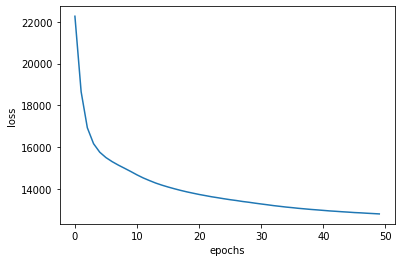

In [ ]:
# Adagrad
plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()


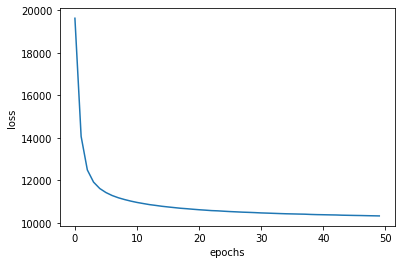

In [ ]:
# Adam with initialize
plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

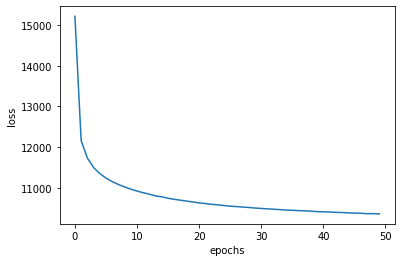

In [ ]:
# Adam without initialize
plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

# 4. Genuine VAE with pytorch lightning

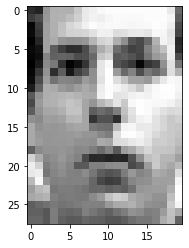

In [ ]:
data_loader = get_FreyFace_data_loader(is_training_data=True)
img = next(iter(data_loader))

# Plot
pixels = img.reshape((-1, IMG_HEIGHT, IMG_WIDTH))[0]
plt.imshow(pixels, cmap='gray')
plt.show()

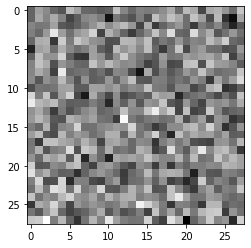

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_out_dim: int, hidden_dim: int, latent_dim: int = 10):
        super().__init__()

        self.latent_dim = latent_dim
        self.common = nn.Sequential(
            nn.Linear(in_out_dim, hidden_dim),
            # nn.ReLU(),
            nn.Tanh(),
            )
        self.model1 = nn.Sequential(
            self.common,
            nn.Linear(hidden_dim, self.latent_dim)
            )
        self.model2 = nn.Sequential(
            self.common,
            nn.Linear(hidden_dim, self.latent_dim)
        )
        # for module in self.modules():
        #     if isinstance(module, nn.Linear):
        #         nn.init.normal_(module.weight, 0, 0.1)
        #         nn.init.constant_(module.bias, 0)

    def forward(self, img):
        """
        Returns
            (Tensor) List of latent codes
        """
        img_flat = img.view(img.size(0), -1)
        return self.model1(img_flat), self.model2(img_flat)


class Decoder(nn.Module):
    def __init__(self, in_out_dim: int, hidden_dim: int, latent_dim: int = 10):
        super().__init__()

        self.latent_dim = latent_dim
        self.model = nn.Sequential(
            nn.Linear(self.latent_dim, hidden_dim),
            # nn.ReLU(),
            nn.Tanh(),
            nn.Linear(hidden_dim, in_out_dim),
            nn.Sigmoid(),
        )
        # for module in self.modules():
        #     if isinstance(module, nn.Linear):
        #         nn.init.normal_(module.weight, 0, 0.1)
        #         nn.init.constant_(module.bias, 0)

    def forward(self, z):
        return self.model(z)


# Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
def VAE_LOSS(recon_x, x, mu, logvar, data_size: int):
    """
    see Appendix B from VAE paper:
    Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    https://arxiv.org/abs/1312.6114
    0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    """
    reconstruction_loss = F.binary_cross_entropy(recon_x, x.view(-1, data_size), reduction='sum')  # , size_average=False)
    # mse_loss = nn.MSELoss(reduction='sum')
    # reconstruction_loss = mse_loss(recon_x, x.view(-1, 784))
    # reconstruction_loss = F.mse_loss(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + KLD


class VAE(pl.LightningModule):
    def __init__(
        self,
        in_out_dim: int,
        hidden_dim: int,
        latent_dim: int = 10
    ):
        super().__init__()

        self.in_out_dim = in_out_dim
        self.encoder = Encoder(in_out_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(in_out_dim, hidden_dim, latent_dim)

    def _reparameterization_trick(self, mean, logvar):
        """
        Parameters
            mean: (Tensor) Mean of the latent Gaussian [B x D]
            logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]

        Returns
            (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mu, sigma = self.encoder(x)
        z         = self._reparameterization_trick(mu, sigma)
        generated = self.decoder(z)
        return generated, mu, sigma

    def training_step(self, batch, batch_idx):
        # real_images, _ = batch
        real_images = batch
        gen_imgs, mu, logvar = self(real_images)
        loss = VAE_LOSS(gen_imgs, real_images, mu, logvar, self.in_out_dim)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # real_images, _ = batch
        real_images = batch
        gen_imgs, mu, logvar = self(real_images)
        loss = VAE_LOSS(gen_imgs, real_images, mu, logvar, self.in_out_dim)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        # real_images, _ = batch
        real_images = batch
        gen_imgs, mu, logvar = self(real_images)
        loss = VAE_LOSS(gen_imgs, real_images, mu, logvar, self.in_out_dim)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-8)
        # optimizer = torch.optim.Adagrad(self.parameters(), lr=0.01, weight_decay=5e-4)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {'scheduler': scheduler, 'monitor': 'val_loss',}
        }

    def sample(self, num_samples: int, current_device: str = 'cpu') -> torch.Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples, self.decoder.latent_dim)
        z = z.to(current_device)

        samples = self.decoder(z)
        return samples


data_loader = get_dataloader(True)

img = next(iter(data_loader))

sample_vae = VAE(in_out_dim=28*28, hidden_dim=500)
sample_vae.eval()

# print(sample_vae)



result = sample_vae(img[0])
result[0].shape

# Plot
# plt.title('Label is {label}'.format(label=label))
pixels = result[0][1].detach().numpy().reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

In [ ]:
pl.seed_everything(0)

gpus = 1
logger = CSVLogger(save_dir='logs', name='vae_net')
# trainer = pl.Trainer(max_epochs=10, accelerator=accelerator, devices=gpus, deterministic=True, logger=logger)
trainer = pl.Trainer(max_epochs=50, deterministic=True, logger=logger)

# MNIST
# vae = VAE(in_out_dim=28*28, hidden_dim=500, latent_dim=2)
# train_loader = get_dataloader(True)
# val_loader = get_dataloader(False)

# Frey face
vae = VAE(in_out_dim=28*20, hidden_dim=200, latent_dim=3)
train_loader = get_FreyFace_data_loader(is_training_data=True)
val_loader = get_FreyFace_data_loader(is_training_data=False)

trainer.fit(vae, train_loader, val_loader)


Global seed set to 0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 113 K 
1 | decoder | Decoder | 113 K 
------------------------------------
226 K     Trainable params
0         Non-trainable params
226 K     Total params
0.907     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1895: PossibleUserWarning: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


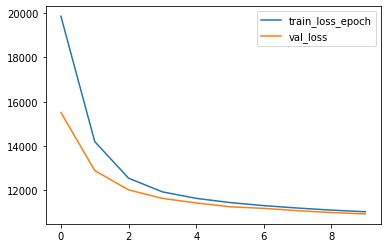

In [ ]:
# 結果確認 Adam with initializers ReLU
log = pd.read_csv('logs/vae_net/version_1/metrics.csv')

log[['train_loss_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss_epoch'].plot()
log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'].plot()
plt.legend()

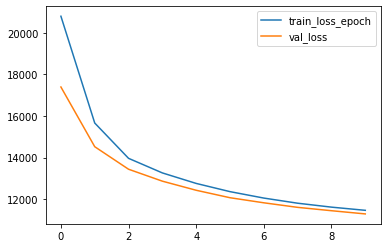

In [ ]:
# 結果確認 Adam with initializers Tanh
log = pd.read_csv('logs/vae_net/version_2/metrics.csv')

log[['train_loss_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss_epoch'].plot()
log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'].plot()
plt.legend()

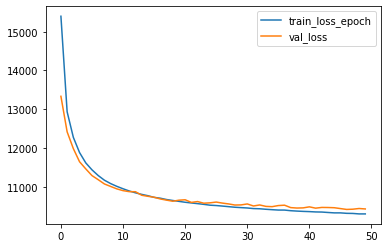

In [ ]:
# 結果確認 Adam without initializers Tanh epoch 50
log = pd.read_csv('logs/vae_net/version_11/metrics.csv')

log[['train_loss_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss_epoch'].plot()
log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'].plot()
plt.legend()

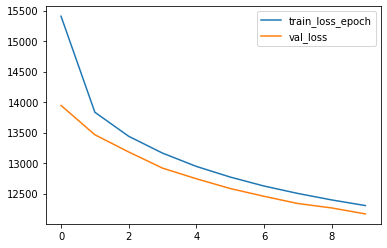

In [ ]:
# 結果確認 Adagrad without initializers Tanh
log = pd.read_csv('logs/vae_net/version_4/metrics.csv')

log[['train_loss_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss_epoch'].plot()
log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'].plot()
plt.legend()

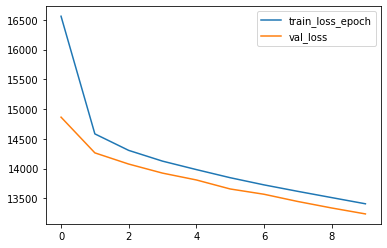

In [ ]:
# 結果確認 Adagrad with xavier initializers Tanh
log = pd.read_csv('logs/vae_net/version_5/metrics.csv')

log[['train_loss_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss_epoch'].plot()
log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'].plot()
plt.legend()

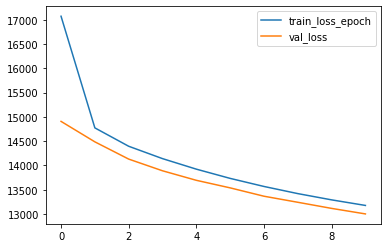

In [ ]:
# 結果確認 Adagrad with initializers Tanh
log = pd.read_csv('logs/vae_net/version_3/metrics.csv')

log[['train_loss_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss_epoch'].plot()
log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'].plot()
plt.legend()

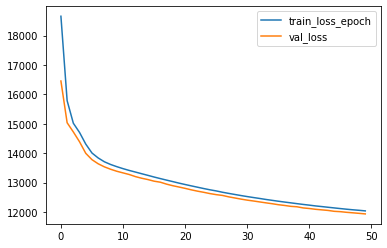

In [ ]:
# 結果確認 Adagrad with initializers Tanh 50 epochs
log = pd.read_csv('logs/vae_net/version_7/metrics.csv')

log[['train_loss_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss_epoch'].plot()
log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'].plot()
plt.legend()

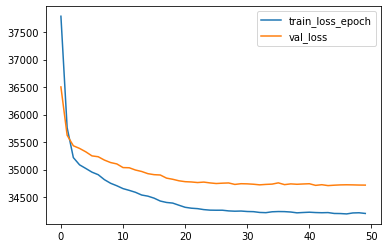

In [ ]:
# 結果確認 Adam without initializers Tanh 50 epochs
log = pd.read_csv('logs/vae_net/version_21/metrics.csv')

log[['train_loss_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss_epoch'].plot()
log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'].plot()
plt.legend()

## 4-2 潜在変数を利用した、データの生成

学習後なら、学習したデータを真似たデータを生成できる

  0%|          | 0/50 [00:00<?, ?it/s]

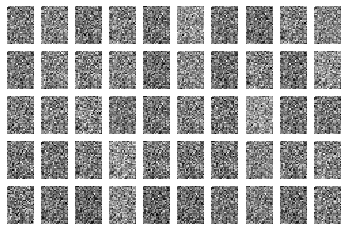

In [ ]:
num: int = 50
imgs = vae.sample(num)

# pixels = imgs[2].detach().numpy().reshape((28, 28))
# plt.imshow(pixels, cmap='gray')
# plt.show()

with torch.no_grad():
    for i in tqdm(range(num)):
        x = imgs[i].reshape((28, 20))
        plt.subplot(5, 10, i + 1)
        plt.imshow(x, interpolation='nearest', cmap = "gray")
        plt.axis('off')

img:  torch.Size([100, 560])


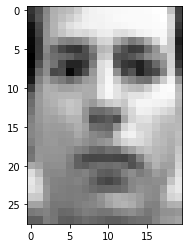

In [ ]:

# data_loader = get_dataloader(True)
data_loader = get_FreyFace_data_loader(is_training_data=True)
img = next(iter(data_loader))
print('img: ', img.shape)

# vae = VAE(in_out_dim=28*28, hidden_dim=100, latent_dim=2)
result = vae(img)

# Plot
# plt.title('Label is {label}'.format(label=label))
pixels = result[0][0].detach().numpy().reshape((28, 20))
plt.imshow(pixels, cmap='gray')
plt.show()